# UCI Heart Disease Dataset: Population Analysis & Data Quality Strategy

## Context
In Notebook 1, we identified that **67.4%** of cases were incomplete (missing at least one value) across *potentially* important variables, with patterns strongly suggesting population-level differences.

Before proceeding with modeling, we need to understand whether the four populations (Cleveland, Hungarian, Switzerland, VA Long Beach) can be reasonably pooled together or should be treated separately (or partially pooled).

## Objective
This notebook compares the four populations to:
- Describe sample sizes and baseline characteristics.
- Quantify and visualize missing data patterns by population.
- Test whether populations differ materially on key variables.
- Make a principled recommendation about pooling vs separate analysis.
- Propose a missing-data handling strategy per variable (overall and by population).

## Research Questions
1. What are the sample sizes and characteristics of each population?
2. How do missing data patterns differ across populations?
3. Are the populations statistically comparable on key variables?
4. Should we pool populations or analyze them separately?
5. What is the appropriate strategy for handling missing data in each variable?

## Notes / Assumptions
- The four datasets represent different clinical sites and data collection protocols; we expect systematic differences.
- Encodings follow the standard UCI Heart Disease documentation (we will flag out-of-domain values rather than auto-correct).
- For comparability tests, we test distributions on observed values; missingness itself is analyzed separately.


In [5]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Statistical utilities
from scipy.stats import chi2_contingency, kruskal

# Setting up general plot styles
from utils.data_visualizations import setup_plot_style
setup_plot_style()

# Utility functions used throughout
from utils.data_quality import calculate_missingness_summary

# Display dataframe numerical values up to 2 decimal points
pd.options.display.float_format = "{:,.2f}".format

warnings.filterwarnings('ignore')


## Data Loading
We use the combined dataframe created in `load_datasets.py` (already includes a `Dataset` identifier column).


In [6]:
from load_datasets import df_combined

# Work on a copy so we don't accidentally mutate the shared object imported from load_datasets.py
df = df_combined.copy()

# Ensure the dataset identifier is categorical (useful for plotting and groupby)
df['Dataset'] = df['Dataset'].astype('category')

# The UCI files can cause numeric columns to be read as object.
# Coerce everything except the dataset label to numeric; non-numeric values become NaN.
feature_cols = [c for c in df.columns if c != 'Dataset']
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()


,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class,Dataset
0,67.00,1.00,4.00,160.00,286.00,0.00,2.00,108.00,1.00,1.50,2.00,3.00,3.00,2,Cleveland
1,67.00,1.00,4.00,120.00,229.00,0.00,2.00,129.00,1.00,2.60,2.00,2.00,7.00,1,Cleveland
2,37.00,1.00,3.00,130.00,250.00,0.00,0.00,187.00,0.00,3.50,3.00,0.00,3.00,0,Cleveland
3,41.00,0.00,2.00,130.00,204.00,0.00,2.00,172.00,0.00,1.40,1.00,0.00,3.00,0,Cleveland
4,56.00,1.00,2.00,120.00,236.00,0.00,0.00,178.00,0.00,0.80,1.00,0.00,3.00,0,Cleveland


---

## 1) Sample Sizes and Population Characteristics
We start by measuring sample size per population and summarizing a few high-level characteristics.

Key derived metrics:
- `% Male`: mean of `Sex` (assuming 1=male, 0=female)
- `Any CVD`: whether `CVD Class > 0` (presence vs absence)


In [7]:
# Sample size by dataset
pop_sizes = (
    df['Dataset']
    .value_counts()
    .rename_axis('Dataset')
    .reset_index(name='N')
)

pop_sizes


,Dataset,N
0,Cleveland,302
1,Hungarian,293
2,VA Long Beach,199
3,Switzerland,122


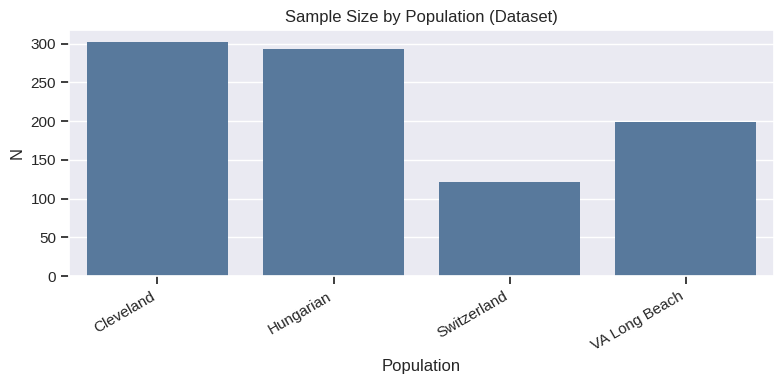

In [8]:
# Plot sample sizes
plt.figure(figsize=(8, 4))
sns.barplot(data=pop_sizes, x='Dataset', y='N', color='#4C78A8')
plt.title('Sample Size by Population (Dataset)')
plt.xlabel('Population')
plt.ylabel('N')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [25]:
# Create a convenient presence/absence target
df['Any CVD'] = (df['CVD Class'] > 0).astype('float')

# Summary characteristics by population
characteristics = df.groupby('Dataset').agg(
    N=('Dataset', 'size'),
    Age_mean=('Age', 'mean'),
    Age_sd=('Age', 'std'),
    Age_median=('Age', 'median'),
    Male_percent=('Sex', lambda x: x.mean() * 100),
    AnyCVD_percent=('Any CVD', lambda x: x.mean() * 100),
    CVDClass_mean=('CVD Class', 'mean'),
    Chol_mean=('Chol', 'mean'),
    RestBP_mean=('Rest BP', 'mean'),
    MaxHR_mean=('Max HR', 'mean'),
).round(2)

characteristics


,N,Age_mean,Age_sd,Age_median,Male_percent,AnyCVD_percent,CVDClass_mean,Chol_mean,RestBP_mean,MaxHR_mean
Dataset,,,,,,,,,,
Cleveland,302,54.41,9.04,55.50,67.88,46.03,0.94,246.74,131.65,149.61
Hungarian,293,47.89,7.74,49.00,72.35,36.18,0.36,251.29,132.59,138.97
Switzerland,122,55.51,8.82,56.00,91.80,93.44,1.81,0.00,130.50,121.51
VA Long Beach,199,59.33,7.83,60.00,96.98,74.37,1.52,178.32,133.72,122.87


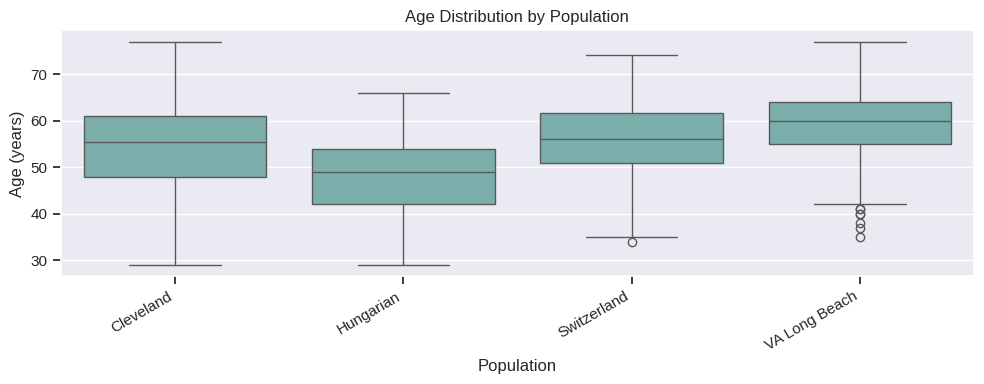

In [10]:
# Visualize age distributions by population
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Dataset', y='Age', color='#72B7B2')
plt.title('Age Distribution by Population')
plt.xlabel('Population')
plt.ylabel('Age (years)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [37]:
df[['Age', 'Dataset']].groupby(by='Dataset').agg(['min', 'max', np.median])

Age             
                min   max median
Dataset                         
Cleveland     29.00 77.00  55.50
Hungarian     29.00 66.00  49.00
Switzerland   34.00 74.00  56.00
VA Long Beach 35.00 77.00  60.00

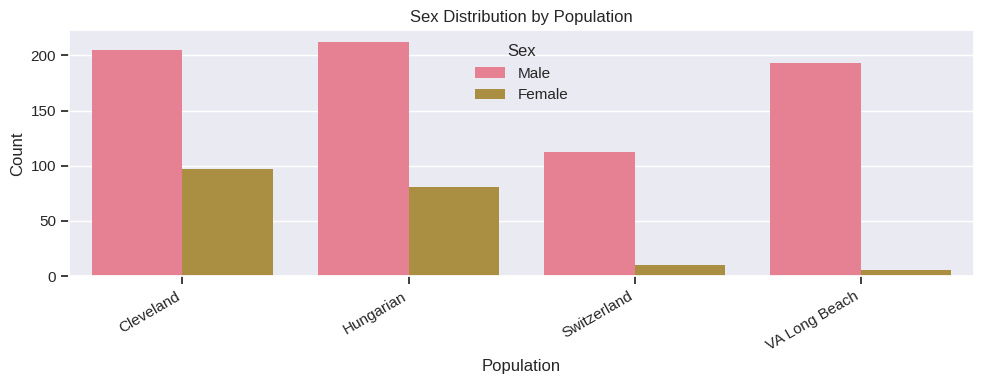

In [11]:
# Visualize Sex distribution by population (assuming 1=Male, 0=Female)
sex_plot_df = df.copy()
sex_plot_df['Sex_Label'] = sex_plot_df['Sex'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(10, 4))
sns.countplot(data=sex_plot_df, x='Dataset', hue='Sex_Label')
plt.title('Sex Distribution by Population')
plt.xlabel('Population')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()


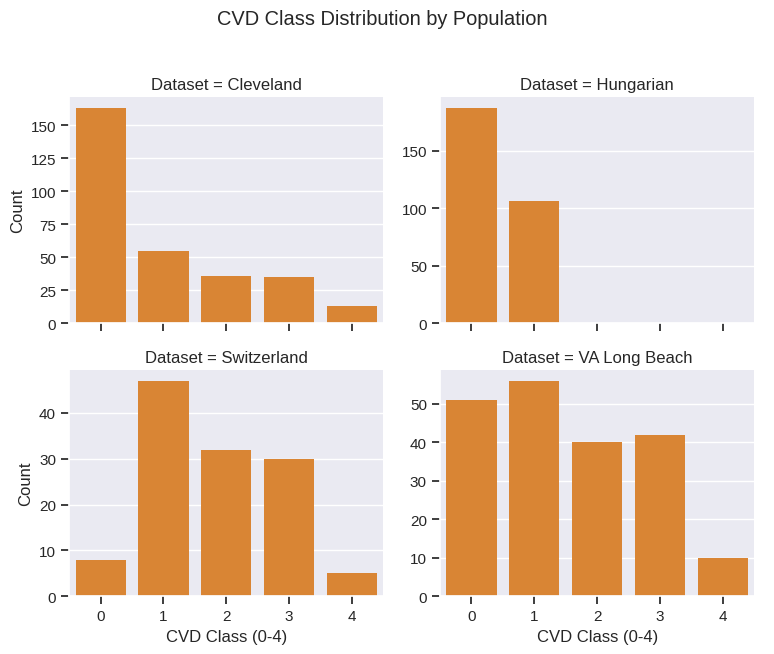

In [ ]:
# Visualize CVD Class distribution by population
g = sns.catplot(
    data=df,
    x='CVD Class',
    kind='count',
    col='Dataset',
    col_wrap=2,
    sharey=False,
    height=3.2,
    aspect=1.2,
    color='#F58518'
)
g.figure.suptitle('CVD Class Distribution by Population', y=1.02)
g.set_axis_labels('CVD Class (0-4)', 'Count')
plt.tight_layout()
plt.show()


---

## 2) Missing Data Patterns Across Populations
Here we quantify missingness at the feature level, then compare missingness patterns across the four populations.

We will:
- Compute missingness % per feature (overall).
- Compute missingness % per feature *within each population*.
- Visualize missingness-by-population as a heatmap.


In [27]:
# Overall missingness summary
missing_overall = calculate_missingness_summary(df)
missing_overall.round(2)


,Feature,Missing_Count,Missing_Percent
0,Ca,608,66.38
1,Thal,483,52.73
2,Slope,308,33.62
3,FBS,89,9.72
4,Oldpeak,62,6.77
5,Rest BP,59,6.44
6,Ex Angina,55,6.00
7,Max HR,55,6.00
8,Chol,30,3.28
9,Rest ECG,2,0.22


In [14]:
# Missingness by population (percent)
missing_by_dataset = df.groupby('Dataset').apply(lambda x: x.isnull().mean() * 100)

# Keep only features with any missingness
missing_by_dataset = missing_by_dataset.loc[:, missing_by_dataset.max() > 0].round(2)
missing_by_dataset


,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal
Dataset,,,,,,,,,,
Cleveland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.32,0.66
Hungarian,0.34,7.85,2.73,0.34,0.34,0.34,0.00,64.51,98.98,90.44
Switzerland,1.64,0.00,60.66,0.82,0.82,0.82,4.92,13.93,95.90,41.80
VA Long Beach,28.14,3.52,3.52,0.00,26.63,26.63,28.14,51.26,98.99,82.91


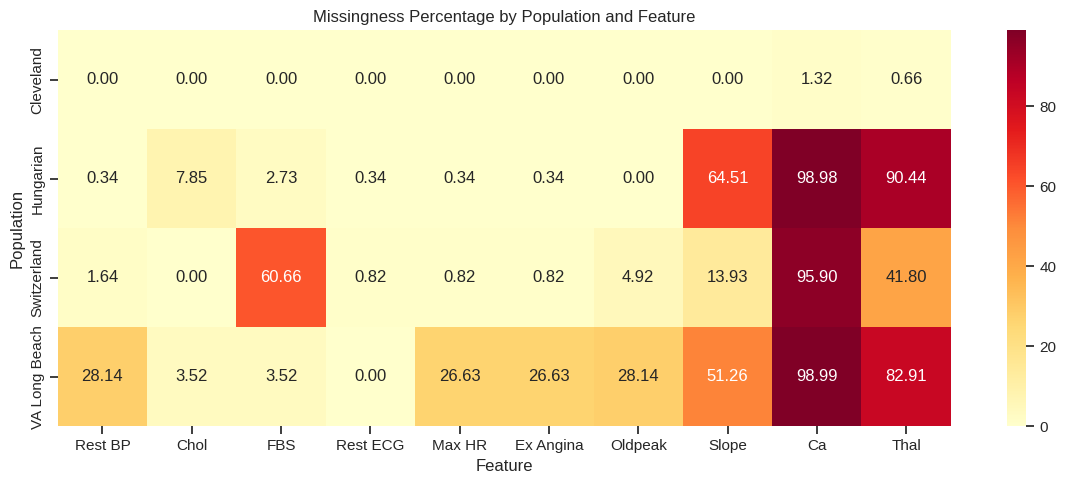

In [15]:
# Heatmap: missingness percentage by dataset and feature
plt.figure(figsize=(12, 5))
sns.heatmap(missing_by_dataset, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Missingness Percentage by Population and Feature')
plt.xlabel('Feature')
plt.ylabel('Population')
plt.tight_layout()
plt.show()


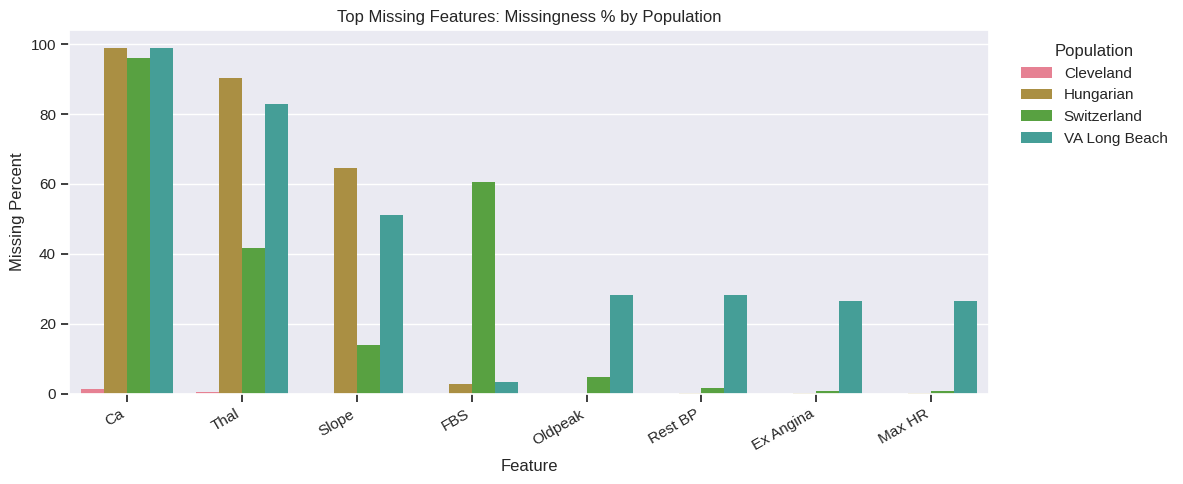

In [16]:
# Compare missingness for the top-missing features across populations
# (This highlights which variables drive incompleteness and where.)
top_features = missing_overall['Feature'].head(8).tolist()

missing_tidy = (
    missing_by_dataset[top_features]
    .reset_index()
    .melt(id_vars='Dataset', var_name='Feature', value_name='Missing_Percent')
)

plt.figure(figsize=(12, 5))
sns.barplot(data=missing_tidy, x='Feature', y='Missing_Percent', hue='Dataset')
plt.title('Top Missing Features: Missingness % by Population')
plt.xlabel('Feature')
plt.ylabel('Missing Percent')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Population', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
# Statistical test: is missingness dependent on population?
# For each feature, test Dataset vs MissingIndicator (Chi-square).

def cramers_v_from_crosstab(crosstab: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.to_numpy().sum()
    r, k = crosstab.shape
    denom = n * max(min(r - 1, k - 1), 1)
    return float(np.sqrt(chi2 / denom))

missingness_tests = []
for feature in missing_by_dataset.columns:
    is_missing = df[feature].isnull()
    ct = pd.crosstab(df['Dataset'], is_missing)

    chi2, p_value, dof, expected = chi2_contingency(ct)
    v = cramers_v_from_crosstab(ct)

    missingness_tests.append({
        'Feature': feature,
        'p_value': p_value,
        "Cramers_V": v,
        'MaxMissingPercent': float(missing_by_dataset[feature].max()),
        'RangeMissingPercent': float(missing_by_dataset[feature].max() - missing_by_dataset[feature].min()),
    })

missingness_tests = pd.DataFrame(missingness_tests).sort_values('p_value')
missingness_tests.head(10)


,Feature,p_value,Cramers_V,MaxMissingPercent,RangeMissingPercent
8,Ca,0.00,0.97,98.99,97.67
9,Thal,0.00,0.79,90.44,89.78
2,FBS,0.00,0.68,60.66,60.66
7,Slope,0.00,0.60,64.51,64.51
0,Rest BP,0.00,0.47,28.14,28.14
4,Max HR,0.00,0.46,26.63,26.63
5,Ex Angina,0.00,0.46,26.63,26.63
6,Oldpeak,0.00,0.45,28.14,28.14
1,Chol,0.00,0.19,7.85,7.85
3,Rest ECG,0.34,0.06,0.82,0.82


Interpretation guide for the table above:
- Very small p-values indicate that missingness is not uniform across populations.
- `Cramers_V` gives an effect-size sense (rule-of-thumb: ~0.1 small, ~0.3 medium, ~0.5 large), but interpret in context.


---

## 3) Statistical Comparability on Key Variables
We test whether populations differ on key baseline variables.

Approach:
- Numeric variables: Kruskal-Wallis (non-parametric across multiple groups).
- Categorical variables: Chi-square test of independence.
- We apply Benjamini-Hochberg FDR correction to control false discoveries across many tests.

Important:
- These tests are sensitive to sample size.
- We'll look at *effect sizes* alongside p-values.


In [18]:
# Helper: Benjamini-Hochberg FDR correction

def benjamini_hochberg(p_values: list[float]) -> np.ndarray:
    p = np.asarray(p_values, dtype=float)
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]

    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]

    out = np.empty_like(q)
    out[order] = q
    return np.clip(out, 0, 1)


# Effect size for Kruskal-Wallis: epsilon-squared (approx)
# Reference: common non-parametric effect size summary

def epsilon_squared_kruskal(H: float, k: int, n: int) -> float:
    if n <= k:
        return np.nan
    return float(max(0.0, (H - k + 1) / (n - k)))


# Effect size for Chi-square: Cramer's V

def cramers_v(chi2: float, n: int, r: int, k: int) -> float:
    denom = n * max(min(r - 1, k - 1), 1)
    return float(np.sqrt(chi2 / denom))


In [19]:
# Define key variables to compare across populations
numeric_vars = ['Age', 'Rest BP', 'Chol', 'Max HR', 'Oldpeak']
cat_vars = ['Sex', 'Chest Pain', 'FBS', 'Rest ECG', 'Ex Angina', 'Slope', 'Ca', 'Thal', 'CVD Class']

# Numeric comparisons (Kruskal-Wallis)
num_results = []
for var in numeric_vars:
    # Drop missing per variable for the test
    temp = df[['Dataset', var]].dropna()

    groups = [g[var].values for _, g in temp.groupby('Dataset')]
    k = len(groups)
    n = len(temp)

    H, p_value = kruskal(*groups)
    eps2 = epsilon_squared_kruskal(H, k=k, n=n)

    num_results.append({
        'Variable': var,
        'Test': 'Kruskal-Wallis',
        'p_value': p_value,
        'EffectSize_eps2': eps2,
        'N_used': n,
    })

num_results = pd.DataFrame(num_results)
num_results['q_value_fdr'] = benjamini_hochberg(num_results['p_value'].tolist())
num_results.sort_values('q_value_fdr')


,Variable,Test,p_value,EffectSize_eps2,N_used,q_value_fdr
2,Chol,Kruskal-Wallis,0.00,0.36,886,0.00
0,Age,Kruskal-Wallis,0.00,0.22,916,0.00
3,Max HR,Kruskal-Wallis,0.00,0.18,861,0.00
4,Oldpeak,Kruskal-Wallis,0.00,0.07,854,0.00
1,Rest BP,Kruskal-Wallis,0.22,0.00,857,0.22


In [20]:
# Categorical comparisons (Chi-square)
cat_results = []
for var in cat_vars:
    temp = df[['Dataset', var]].dropna()
    ct = pd.crosstab(temp['Dataset'], temp[var])

    chi2, p_value, dof, expected = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, k = ct.shape
    v = cramers_v(chi2, n=n, r=r, k=k)

    cat_results.append({
        'Variable': var,
        'Test': 'Chi-square',
        'p_value': p_value,
        'EffectSize_CramersV': v,
        'N_used': int(n),
        'N_levels': int(k),
    })

cat_results = pd.DataFrame(cat_results)
cat_results['q_value_fdr'] = benjamini_hochberg(cat_results['p_value'].tolist())
cat_results.sort_values('q_value_fdr')


,Variable,Test,p_value,EffectSize_CramersV,N_used,N_levels,q_value_fdr
3,Rest ECG,Chi-square,0.00,0.44,914,3,0.00
8,CVD Class,Chi-square,0.00,0.30,916,5,0.00
1,Chest Pain,Chi-square,0.00,0.21,916,4,0.00
5,Slope,Chi-square,0.00,0.31,608,3,0.00
0,Sex,Chi-square,0.00,0.30,916,2,0.00
2,FBS,Chi-square,0.00,0.29,827,2,0.00
4,Ex Angina,Chi-square,0.00,0.25,861,2,0.00
7,Thal,Chi-square,0.00,0.27,433,3,0.00
6,Ca,Chi-square,0.07,0.13,308,4,0.07


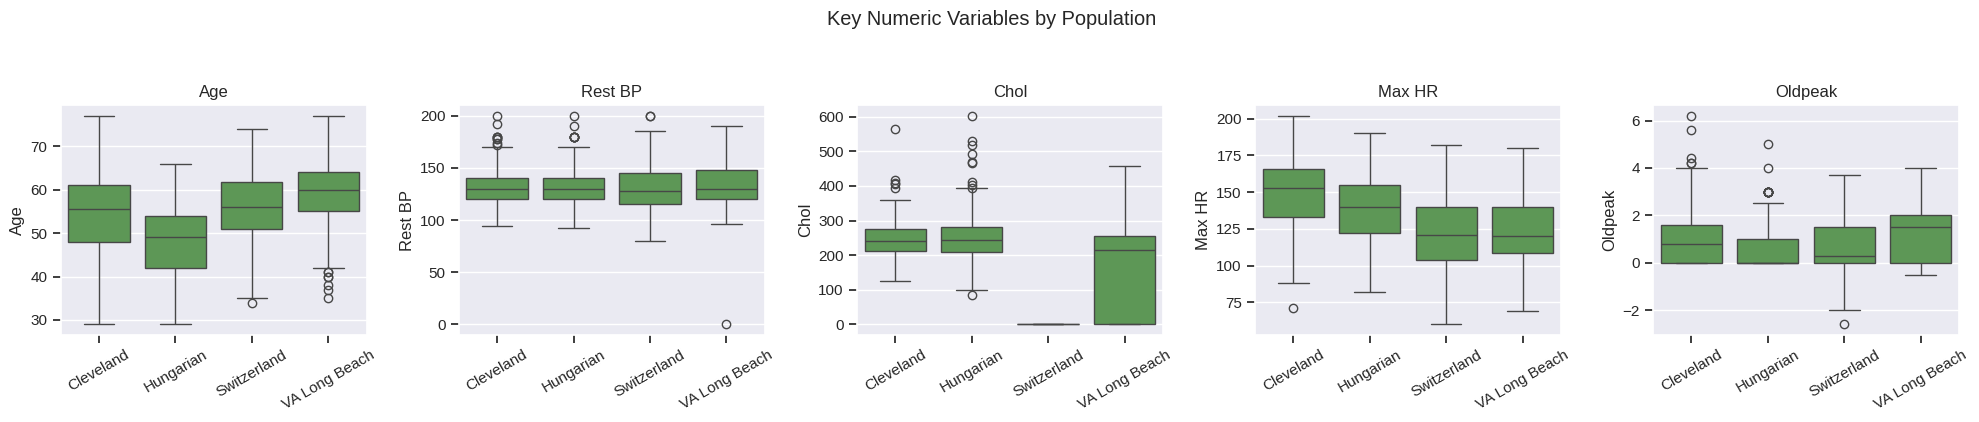

In [ ]:
# Visualization: numeric variables by population 
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_vars), figsize=(4 * len(numeric_vars), 4))

for ax, var in zip(axes, numeric_vars):
    sns.boxplot(data=df, x='Dataset', y=var, ax=ax, color='#54A24B')
    ax.set_title(var)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Key Numeric Variables by Population', y=1.05)
plt.tight_layout()
plt.show()


---

## 4) Pool vs Separate Analysis
We combine evidence from:
- Missingness differences by population.
- Distributional differences in key variables.

Decision options:
- **Pool fully**: treat data as IID (rarely appropriate here).
- **Pool with safeguards**: include `Dataset` as a feature, impute within population, and evaluate with stratified/group-aware validation.
- **Analyze separately**: train/validate within each population (or only pool subsets with similar measurement patterns).

Below we create a simple dashboard to summarize where differences are strongest.


In [22]:
# Summarize which variables show strong missingness differences by population
# Heuristic thresholds (adjust as needed):
# - q_value (not computed here for missingness tests) is replaced by raw p-value; treat this as screening.
# - RangeMissingPercent > 10 highlights practically large gaps.

missingness_flags = missingness_tests.copy()
missingness_flags['LargeGap'] = missingness_flags['RangeMissingPercent'] > 10
missingness_flags['VeryHighMissing'] = missingness_flags['MaxMissingPercent'] > 30

missingness_flags.sort_values(['VeryHighMissing', 'LargeGap', 'p_value'], ascending=[False, False, True]).head(12)


,Feature,p_value,Cramers_V,MaxMissingPercent,RangeMissingPercent,LargeGap,VeryHighMissing
8,Ca,0.00,0.97,98.99,97.67,True,True
9,Thal,0.00,0.79,90.44,89.78,True,True
2,FBS,0.00,0.68,60.66,60.66,True,True
7,Slope,0.00,0.60,64.51,64.51,True,True
0,Rest BP,0.00,0.47,28.14,28.14,True,False
4,Max HR,0.00,0.46,26.63,26.63,True,False
5,Ex Angina,0.00,0.46,26.63,26.63,True,False
6,Oldpeak,0.00,0.45,28.14,28.14,True,False
1,Chol,0.00,0.19,7.85,7.85,False,False
3,Rest ECG,0.34,0.06,0.82,0.82,False,False


In [23]:
# Quick combined summary for comparability on observed values
# (q_value_fdr < 0.05 is a common threshold; effect sizes help interpret magnitude.)

num_sig = num_results[num_results['q_value_fdr'] < 0.05].copy()
cat_sig = cat_results[cat_results['q_value_fdr'] < 0.05].copy()

summary_pooling = pd.Series({
    'Numeric variables tested': len(num_results),
    'Numeric variables significant (FDR<0.05)': len(num_sig),
    'Categorical variables tested': len(cat_results),
    'Categorical variables significant (FDR<0.05)': len(cat_sig),
    'Features with any missingness': int((df.isnull().sum() > 0).sum()),
    'Features with >30% missing in at least one population': int((missing_by_dataset.max() > 30).sum()) if 'missing_by_dataset' in globals() else np.nan,
})

summary_pooling


Numeric variables tested                                  5
Numeric variables significant (FDR<0.05)                  4
Categorical variables tested                              9
Categorical variables significant (FDR<0.05)              8
Features with any missingness                            10
Features with >30% missing in at least one population     4
dtype: int64

**Recommendation (working, to validate after reviewing outputs):**
- Given strong population-dependent missingness, **fully pooling without adjustments is not appropriate**.
- A reasonable default is **pooling with safeguards**:
  - Impute *within population* (Dataset) to respect different measurement patterns.
  - Add missingness indicators for variables where missingness is likely informative.
  - Include `Dataset` as a feature or use group-aware evaluation (e.g., validate per site).
- For variables that are *heavily missing* in some populations (e.g., >30-40% with large between-pop gaps), consider:
  - Dropping them from a pooled model, or
  - Running population-specific models / analyses where the variable is reliably measured.


---

## 5) Strategy for Handling Missing Data (Per Variable)
We now translate the missingness patterns into a practical strategy.

We will build a table with:
- Overall missingness
- Max missingness within a population
- Missingness range across populations
- A suggested action (impute vs indicator vs drop vs population-specific)

This is meant as a **starting point**; we should iterate based on modeling goals and validation results.


In [24]:
# Build a per-variable missingness strategy table

# Identify which variables are categorical vs numeric (based on known UCI schema)
cat_features = set(['Sex', 'Chest Pain', 'FBS', 'Rest ECG', 'Ex Angina', 'Slope', 'Ca', 'Thal', 'CVD Class'])

strategy_rows = []
for feature in [c for c in df.columns if c not in ['Dataset', 'Any CVD']]:
    overall_missing = float(df[feature].isnull().mean() * 100)
    if feature in missing_by_dataset.columns:
        max_miss = float(missing_by_dataset[feature].max())
        min_miss = float(missing_by_dataset[feature].min())
        range_miss = max_miss - min_miss
    else:
        max_miss, min_miss, range_miss = 0.0, 0.0, 0.0

    # Simple heuristic recommendation rules
    if overall_missing < 5 and range_miss < 5:
        rec = 'Low missingness: simple imputation (global) acceptable; consider Dataset-wise impute if pooling.'
    elif overall_missing < 20 and range_miss < 10:
        rec = 'Moderate missingness: impute (prefer Dataset-wise) + consider missingness indicator.'
    elif max_miss >= 30 and range_miss >= 10:
        rec = 'Population-dependent high missingness: prefer Dataset-wise imputation + missingness indicator; consider dropping from pooled model or analyzing populations separately.'
    elif overall_missing >= 30:
        rec = 'High missingness overall: consider multiple imputation or dropping feature; consider restricting to populations with adequate measurement.'
    else:
        rec = 'Mixed missingness: impute within Dataset and add missingness indicator; validate carefully.'

    ftype = 'Categorical' if feature in cat_features else 'Numeric'

    strategy_rows.append({
        'Feature': feature,
        'Type': ftype,
        'MissingOverall_%': round(overall_missing, 2),
        'MissingMaxByPop_%': round(max_miss, 2),
        'MissingRangeByPop_%': round(range_miss, 2),
        'Recommendation': rec,
    })

missing_strategy = pd.DataFrame(strategy_rows).sort_values(['MissingMaxByPop_%', 'MissingOverall_%'], ascending=False)
missing_strategy


,Feature,Type,MissingOverall_%,MissingMaxByPop_%,MissingRangeByPop_%,Recommendation
11,Ca,Categorical,66.38,98.99,97.67,Population-dependent high missingness: prefer ...
12,Thal,Categorical,52.73,90.44,89.78,Population-dependent high missingness: prefer ...
10,Slope,Categorical,33.62,64.51,64.51,Population-dependent high missingness: prefer ...
5,FBS,Categorical,9.72,60.66,60.66,Population-dependent high missingness: prefer ...
9,Oldpeak,Numeric,6.77,28.14,28.14,Mixed missingness: impute within Dataset and a...
3,Rest BP,Numeric,6.44,28.14,28.14,Mixed missingness: impute within Dataset and a...
7,Max HR,Numeric,6.00,26.63,26.63,Mixed missingness: impute within Dataset and a...
8,Ex Angina,Categorical,6.00,26.63,26.63,Mixed missingness: impute within Dataset and a...
4,Chol,Numeric,3.28,7.85,7.85,Moderate missingness: impute (prefer Dataset-w...
6,Rest ECG,Categorical,0.22,0.82,0.82,Low missingness: simple imputation (global) ac...


## Next Steps
- Decide the modeling plan:
  - pooled-with-safeguards vs population-specific.
- Implement the chosen missing-data approach consistently (ideally in `utils/data_cleaning.py`).
- When we move to modeling, use dataset-aware validation (e.g., report performance per population).
